In [6]:
import os
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import cv2

In [7]:
dataset_path=dataset_path = "/kaggle/input/datasets/omrathod2003/140-most-popular-crops-image-dataset/RGB_224x224/RGB_224x224"

In [8]:
train_dir=os.path.join(dataset_path,"/kaggle/input/datasets/omrathod2003/140-most-popular-crops-image-dataset/RGB_224x224/RGB_224x224/train")

In [9]:

classes=os.listdir(train_dir)

In [10]:
len(classes)

139

In [11]:
import random
random.sample(classes,5)

['Oregano plant',
 'Olives plant',
 'Oranges plant',
 'Figs plant',
 'Habanero pepper plant']

In [12]:
def show_sample_images(num_classes=4):
  fig,axes=plt.subplots(num_classes,5,figsize=(15,3*num_classes))
  for i,class_name in enumerate(random.sample(classes,num_classes)):
    class_path=os.path.join(train_dir,class_name)
    images=os.listdir(class_path)
    for j in range(min(5, len(images))):
      img_path=os.path.join(class_path,images[j])
      img=Image.open(img_path)
      axes[i,j].imshow(img)
      axes[i,j].set_title(class_name)
      axes[i,j].axis("off")
  plt.tight_layout()
  plt.show()

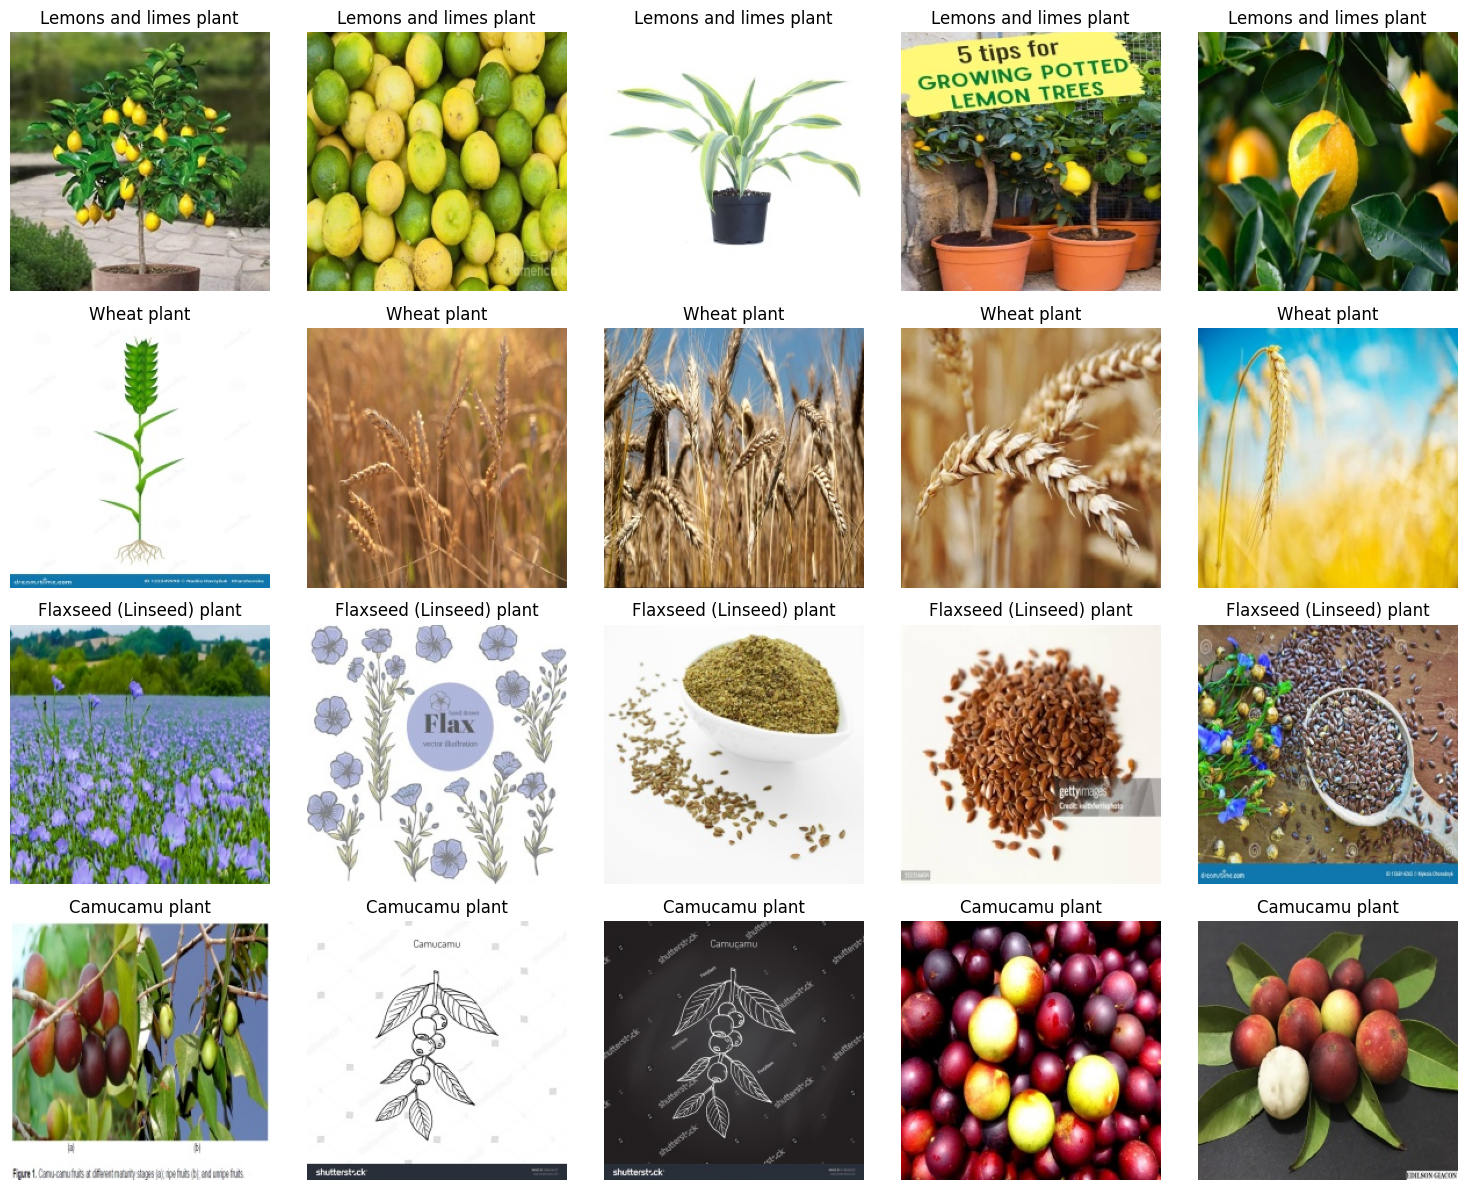

In [13]:
show_sample_images()

In [14]:
import torch
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

In [15]:
transform=transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

In [16]:
train_dataset=ImageFolder(os.path.join(dataset_path,"train"),transform=transform)
val_dataset=ImageFolder(os.path.join(dataset_path,"val"),transform=transform)
test_dataset=ImageFolder(os.path.join(dataset_path,"test"),transform=transform)

In [17]:
train_loader=DataLoader(train_dataset,batch_size=128,shuffle=True,num_workers=4)
val_loader=DataLoader(val_dataset,batch_size=64,shuffle=False)
test_loader=DataLoader(test_dataset,batch_size=64,shuffle=False)

In [18]:
import torchvision.models as models
import torch.nn as nn

In [19]:
device=torch.device("cuda"if torch.cuda.is_available()else"cpu")

In [20]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [21]:
device

device(type='cuda')

In [22]:
model=models.resnet18(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
100%|██████████| 44.7M/44.7M [00:00<00:00, 194MB/s]


In [23]:
for param in model.parameters():
    param.require_grad=False

In [24]:
num_classes=len(train_dataset.classes)
model.fc=nn.Linear(model.fc.in_features,num_classes)

In [25]:
import torch.optim as optim
import torch.nn.functional as F

In [26]:
optimizer=optim.Adam(model.parameters(),lr=0.001)
criterion=nn.CrossEntropyLoss()

In [27]:
def train_one_epoch(model,loader):
    model.train()
    running_loss=0
    
    for images,labels in loader:
        images,labels=images.to(device),labels.to(device)
        optimizer.zero_grad()
        outputs=model(images)
        loss=criterion(outputs,labels)
        loss.backward()
        optimizer.step()
        running_loss+=loss.item()
    return running_loss/len(loader)    

In [28]:
def evaluate(model,loader):
    model.eval()
    correct=0
    total=0

    with torch.no_grad():
        for images,labels in loader:
            images,labels=images.to(device),labels.to(device)
            outputs=model(images)
            _,predicted=torch.max(outputs.data,1)
            total+=labels.size(0)
            correct+=(predicted==labels).sum().item()
    
    return correct/total

In [29]:
print(device)

cuda


In [30]:
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [31]:
epochs=5
for epoc in range(epochs):
    train_loss=train_one_epoch(model,train_loader)
    val_acc=evaluate(model,val_loader)
    print(f"Epoch{epochs+1},Train Loss:{train_loss:.4f},val Accuracy:{val_acc:.4f}")

Epoch6,Train Loss:3.2759,val Accuracy:0.2931
Epoch6,Train Loss:2.2886,val Accuracy:0.4513
Epoch6,Train Loss:1.7232,val Accuracy:0.3930
Epoch6,Train Loss:1.2836,val Accuracy:0.4650
Epoch6,Train Loss:0.9172,val Accuracy:0.5237


In [32]:
test_acc=evaluate(model,test_loader)

In [33]:
print(f"Test Accuracy:{test_acc:.4f}")

Test Accuracy:0.5073


In [34]:
def visualize_predictions(model,loader,n=5):
    model.eval()
    images_shown=0
    classes_names=train_dataset.classes

    with torch.no_grad():
        for images,labels in loader:
            images=images.to(device)
            outputs=model(images)
            _,preds=torch.max(outputs,1)
            
            for i in range(n):
                img=images[i].cpu().permute(1,2,0).numpy()
                plt.imshow((img*0.229+0.485))
                plt.title(f"True:{classes_names[labels[i]]},pred:{classes_names[preds[i]]}")
                plt.axis("off")
                plt.show()

                images_shown+=1
                if images_shown>=n:
                    return

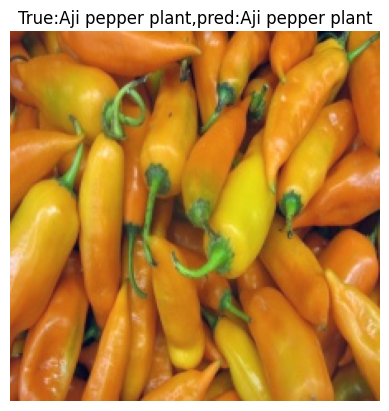

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.02352938..1.041143].


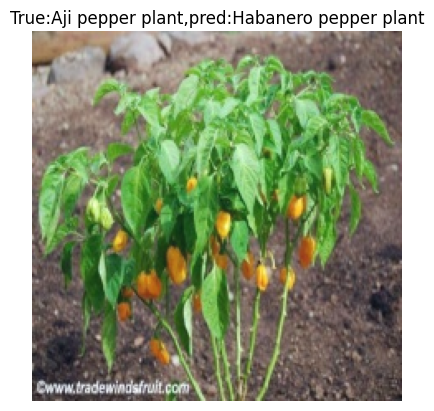

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.007843137..1.08956].


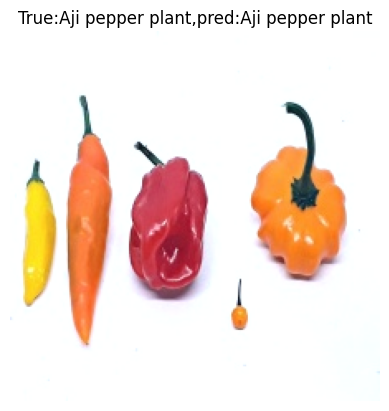

In [35]:
visualize_predictions(model,test_loader,3)

In [36]:
import joblib

In [37]:
model_data={
    "model_state_dict":model.state_dict(),
    "class_to_idx":train_dataset.class_to_idx
}

In [38]:
model_data

{'model_state_dict': OrderedDict([('conv1.weight',
               tensor([[[[-1.1962e-02, -9.6857e-03, -2.7323e-03,  ...,  5.4736e-02,
                           1.6876e-02, -3.2547e-03],
                         [ 5.8918e-03,  3.5657e-03, -1.0396e-01,  ..., -2.7260e-01,
                          -1.2521e-01,  3.5205e-03],
                         [-2.3662e-02,  4.6095e-02,  3.0105e-01,  ...,  5.2675e-01,
                           2.6288e-01,  6.7574e-02],
                         ...,
                         [-2.6691e-02,  1.2702e-02,  6.9951e-02,  ..., -3.3022e-01,
                          -4.1934e-01, -2.6308e-01],
                         [ 3.5213e-02,  3.6515e-02,  5.7437e-02,  ...,  4.2845e-01,
                           4.0144e-01,  1.5691e-01],
                         [-1.0217e-02, -1.6830e-02, -2.6204e-02,  ..., -1.5402e-01,
                          -8.1216e-02, -5.6807e-03]],
               
                        [[-2.8416e-03, -1.3793e-02, -1.8120e-02,  ...,  3.9196e-

In [39]:
joblib.dump(model_data,"crop_classifier_model.pkl")

['crop_classifier_model.pkl']

In [40]:
torch.save(model.state_dict(), "crop_classifier_model.pth")

In [41]:
print(os.listdir())

['crop_classifier_model.pkl', 'crop_classifier_model.pth', '.virtual_documents']


In [42]:
print(os.listdir("/kaggle/working"))

['crop_classifier_model.pkl', 'crop_classifier_model.pth', '.virtual_documents']


In [43]:
print(os.getcwd())
print(os.listdir())

/kaggle/working
['crop_classifier_model.pkl', 'crop_classifier_model.pth', '.virtual_documents']


In [44]:
!pip install streamlit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.1/9.1 MB 74.7 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 118.5 MB/s eta 0:00:0000:01


In [45]:
import streamlit as st
import torch
import torchvision.transforms as transforms
from torchvision import models
from PIL import Image
import joblib
import io


In [46]:
model_data=joblib.load("crop_classifier_model.pkl")

In [47]:
model=models.resnet18(pretrained=False)

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [48]:
model.fc=torch.nn.Linear(model.fc.in_features,len(model_data["class_to_idx"]))

In [49]:
model.load_state_dict(model_data["model_state_dict"])

<All keys matched successfully>

In [50]:
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [51]:
idx_to_class={v:k for k,v in model_data["class_to_idx"].items()}

In [52]:
transform=transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

In [53]:
st.title("Crop Classifier")
st.markdown("upload a crop image and the model will predict which crop it is .")
uploaded_file=st.file_uploader("upload an image",type=["jpg","jpeg","png"])
if uploaded_file is not None:
    image=Image.open(uploaded_file).convert("RGB")
    st.image(image,caption="Uploaded Image",use_container_width=True)
    input_tensor=transform(image).unsqueeze(0)
    with torch.no_grad():
        output=model(input_tensor)
        _,predicted=torch.max(output,1)
    
        class_name=idx_to_class[predicted.item()]
    st.success(f"Predicted Crop:**{class_name}**")     
        

2026-02-12 14:03:04.223 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2026-02-12 14:03:04.367 
  command:

    streamlit run /usr/local/lib/python3.12/dist-packages/colab_kernel_launcher.py [ARGUMENTS]
2026-02-12 14:03:04.368 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2026-02-12 14:03:04.369 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2026-02-12 14:03:04.369 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2026-02-12 14:03:04.370 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2026-02-12 14:03:04.370 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2026-02-12 14:03:04.371 Thread 'MainThread': mi